In [1]:
#bibliotecas necesarias para el funcionamiento
import pandas                  as pd                     #manejo y manipulación de dataframes
import scipy
import numpy                   as np                     #soporte matricial y vectorial
import matplotlib.pyplot       as plt                    #graficos
import joblib
from   sklearn.model_selection import GridSearchCV       #optimización de hiperparametros
from   sklearn                 import metrics            #metricas de validación
from   sklearn.model_selection import train_test_split   #segmentación de muestra
from   sklearn.linear_model    import LogisticRegression #clasificador 
from   sklearn.impute          import SimpleImputer      
from   sklearn.compose         import ColumnTransformer
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import LabelEncoder
from   sklearn.preprocessing   import OneHotEncoder,StandardScaler
from   sklearn.preprocessing   import KBinsDiscretizer
from   sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

##### Limpeza de base de datos "casos-asociados-a-covid-1920jul.csv" 

In [2]:
columnas=["SEXO","OBESIDAD","DIABETES","EPOC","ASMA","CARDIOVASCULAR","RENAL CRONICA","INMUNOSUPRESION","HIPERTENSION","TABAQUISMO","TIPO PACIENTE","EDAD"]

In [3]:
filelocal="casos-asociados-a-covid-1920jul.csv"
#Nos quedamos unicamente con los positivos
def getData(file,columnas,filtro="positivo"):
    df=pd.read_csv(file,header=0,sep=",",encoding='utf-8',low_memory=False)
    df=df.query(filtro+"=='Positivo SARS-CoV-2'")
    df=df.loc[:,columnas]
    print("casos totales")
    print(df.shape)
    return df  

In [4]:
#quitamos aquellos datos donde se ingora la condicion
def limpiaData(data,feature,conditions):
    df=data
    for i in feature:
        df = df.drop(df[(df[i] == conditions)].index)
    print("datos finales "+str(df.shape))    
    return df

In [13]:
df=getData(filelocal,columnas) 
feat=['OBESIDAD','DIABETES','EPOC','ASMA',"CARDIOVASCULAR",'RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION","TABAQUISMO"]
df=limpiaData(df,feat,'SE IGNORA')

casos totales
(349396, 12)
datos finales (347353, 12)


In [14]:
#Filtramos datos para solo obtener personas menores a 100 años
df=df.query("EDAD<100")

In [15]:
#Guardamos en csv datos limpios que utilizamos en EJERCICIO 1
df.to_csv("covidfilter.csv")

In [33]:
#df = pd.read_csv("covidfilter.csv",index_col = 0)

In [34]:
#Para disminuir el tiempo sacamos muestra aleatoria de tamaño 5000 
df = df.sample(n=5000, random_state=1)
df.head()

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,TABAQUISMO,TIPO PACIENTE,EDAD
378728,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,NO,HOSPITALIZADO,54
4129,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,35
697604,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,NO,AMBULATORIO,47
594506,HOMBRE,NO,SI,NO,NO,NO,SI,NO,SI,NO,HOSPITALIZADO,78
605893,HOMBRE,NO,SI,NO,NO,NO,NO,NO,SI,NO,AMBULATORIO,70


### Ejercicio 2

### Aplique OneHotEncoder a las variables categóricas.

In [35]:
#proporción de pacientes ambulatorios y hospitalizados
df["TIPO PACIENTE"].value_counts()

AMBULATORIO      3565
HOSPITALIZADO    1435
Name: TIPO PACIENTE, dtype: int64

In [36]:
y=LabelEncoder().fit_transform(df["TIPO PACIENTE"])
X=df.drop(["TIPO PACIENTE"],axis=1)#Elimina primera columna
X.head(1)

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,TABAQUISMO,EDAD
378728,HOMBRE,NO,NO,NO,NO,NO,NO,NO,NO,NO,54


In [37]:
#crea un pipeline para generar el modelo
def modelo(X_train, y_train,numeric_features,categorical_features):
    numeric_transformer = Pipeline(steps=[
    ('imputer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))])
    categorical_transformer = Pipeline(steps=[
        #imputacion por el valor más frecuente
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    #onehot encoder para las varibales categoricas    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    #el pipeline con el procesamienot y el claificador
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gridsearh())])
    modelo=clf.fit(X_train, y_train)
    return modelo

In [38]:
#El grid search prueba con varios modelos usando holdout 70-30
def gridsearh():
    clf = LogisticRegression(fit_intercept=True,solver='lbfgs',tol=1e-5,max_iter=75,n_jobs=8)
    grid_values = {'penalty': [ 'l2'],'C':np.logspace(-5, 5, 100)}
    """se evalúan todas las combinaciones posibles de valores de parámetros y 
    se conserva la mejor combinacion."""   
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
    return grid_clf_acc

In [39]:
#El score obtenido con el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
categorical_features = ['SEXO','OBESIDAD','DIABETES','EPOC','ASMA','CARDIOVASCULAR','RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION"]
numeric_features=['EDAD']
modelo=modelo(X_train, y_train,numeric_features,categorical_features)
print("model score: %.3f" % modelo.score(X_test, y_test))

model score: 0.764


In [22]:
print(modelo.named_steps['classifier'].best_estimator_.coef_)
print(modelo.named_steps['classifier'].best_estimator_.intercept_)

[[ 0.61990869  0.20201276 -0.2587554  -0.09822209  0.04147945 -0.29034482
   0.23360218 -0.65228654  0.5955439  -0.08474865  0.028006   -0.21151228
   0.15476964 -0.97615613  0.91941349 -0.08472019  0.02797755 -0.19480082
   0.13805818]]
[-0.06657272]


In [23]:
print(modelo.named_steps['classifier'].best_estimator_)

LogisticRegression(C=2.848035868435799, max_iter=75, n_jobs=8, tol=1e-05)


### De los modelos anteriores obtenga la matriz de confusión y la curva ROC.

In [24]:
#calculo de las probabilidades y el AUC
probs = modelo.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

Matriz de cnfusión
[[942 122]
 [253 183]]


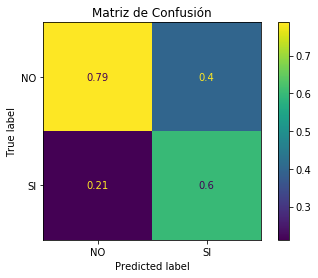

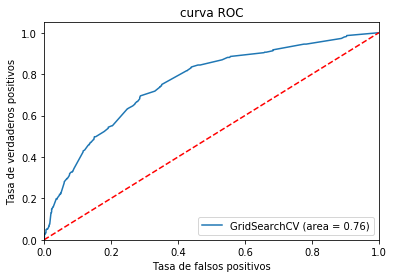

In [25]:
#la matriz de confusion
print("Matriz de cnfusión")
predict=modelo.predict(X_test)
cm = metrics.confusion_matrix(y_test, predict)
print(cm) 

#la matriz de confusion en scikit learn noraalizado

disp=metrics.plot_confusion_matrix(modelo, X_test, y_test,normalize="pred",display_labels=np.array(["NO","SI"]))
disp.ax_.set_title("Matriz de Confusión")
disp.confusion_matrix

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Haga una optimización de hiperpametros priorizando la precisión.
### Haga una gráficaca de Precision-Recall vs Threshold

In [26]:
predictions=modelo.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.75
Precision score:  0.6
Recall score:  0.4197247706422018
F1 score:  0.49392712550607293


(array([375., 156., 140., 139., 114.,  34., 161.,  28.,  48., 102.,  51.,
         62.,  10.,  35.,  13.,   2.,  11.,   7.,  12.]),
 array([0.05126508, 0.10027253, 0.14927999, 0.19828745, 0.2472949 ,
        0.29630236, 0.34530981, 0.39431727, 0.44332472, 0.49233218,
        0.54133964, 0.59034709, 0.63935455, 0.688362  , 0.73736946,
        0.78637691, 0.83538437, 0.88439183, 0.93339928, 0.98240674]),
 <a list of 19 Patch objects>)

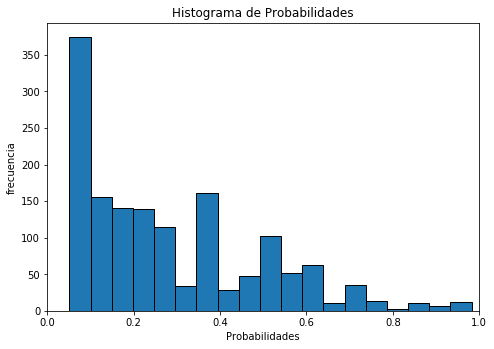

In [27]:
fig=plt.figure()
axes=fig.add_axes([1,1,1.0,1.0])
axes.set_title("Histograma de Probabilidades")
axes.set_xlim(0,1)
axes.set_xlabel("Probabilidades")
axes.set_ylabel("frecuencia")
axes.hist(preds,bins=19,edgecolor="black")

(0, 1)

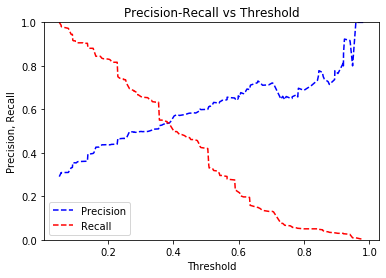

In [28]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1]) 
pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### Modelo 2 Kernel Lineal

Intentos

In [2]:
covid = pd.read_csv("covid_clean.csv",sep=",",header=0, index_col = 0)
covid.head()

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL.CRONICA,INMUNOSUPRESION,HIPERTENSION,TABAQUISMO,TIPO.PACIENTE,EDAD
1,0,0,0,0,0,0,0,0,0,0,0,51
2,0,0,0,0,0,0,0,0,0,1,0,37
3,1,0,0,0,0,0,0,0,0,0,0,18
4,1,0,0,0,0,0,0,0,0,0,0,40
5,0,0,1,0,0,0,1,0,1,0,1,78


In [5]:
df1 = covid.sample(n=500, random_state=1)
df1.head()

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL.CRONICA,INMUNOSUPRESION,HIPERTENSION,TABAQUISMO,TIPO.PACIENTE,EDAD
249403,1,0,0,0,0,0,0,0,0,0,1,54
4106,0,0,0,0,0,0,0,0,0,0,0,35
329402,1,0,0,0,0,0,0,0,0,0,0,47
288674,1,0,1,0,0,0,1,0,1,0,1,78
300003,1,0,1,0,0,0,0,0,1,0,0,70


In [6]:
y=LabelEncoder().fit_transform(df1["TIPO.PACIENTE"])
X=df1.drop(["TIPO.PACIENTE"],axis=1)#Elimina primera columna

In [8]:
from sklearn import svm

ValueError: X.shape[1] = 2 should be equal to 11, the number of features at training time

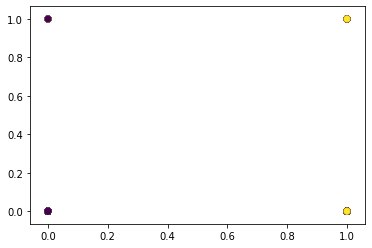

In [27]:
svmm = svm.SVC(kernel='linear', C=1)
svmm.fit(X, y)
plt.scatter(X['SEXO'][:],X['OBESIDAD'][:],c=y)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x0 = np.linspace(xlim[0], xlim[1], 100)
y0 = np.linspace(ylim[0], ylim[1], 100)
x1,y1=np.meshgrid(x0,y0)
xy = np.vstack([x1.ravel(), y1.ravel()]).T
z =svmm.decision_function(xy).reshape(y1.shape)
ax.contour(x1, y1, z, colors='k', levels=[-1,0,1], alpha=0.5,
           linestyles=['--','-','--'])
plt.show()

In [29]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = make_pipeline(StandardScaler(),
                  LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)
S = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [30]:
S.f

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [43]:
#crea un pipeline para generar el modelo
def modelo(X_train, y_train,numeric_features,categorical_features):
    numeric_transformer = Pipeline(steps=[
    ('imputer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))])
    categorical_transformer = Pipeline(steps=[
        #imputacion por el valor más frecuente
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    #onehot encoder para las varibales categoricas    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    #el pipeline con el procesamienot y el claificador
    clf = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])
    modelo=clf.fit(X_train, y_train)
    return modelo

In [44]:
#El score obtenido con el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
categorical_features = ['SEXO','OBESIDAD','DIABETES','EPOC','ASMA','CARDIOVASCULAR','RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION"]
numeric_features=['EDAD']
modelo=modelo(X_train, y_train,numeric_features,categorical_features)
print("model score: %.3f" % modelo.score(X_test, y_test))

ValueError: could not convert string to float: 'HOMBRE'